TASK:-
1. define train_ds and test_df
2. visualizing the batch images using plyplot 
3. getting into conveyor pipeline (preprocessing and model training simultaneously for every image )

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [9]:
from tensorflow.keras.utils import load_img ,array_to_img ,img_to_array , image_dataset_from_directory 


In [10]:
# this is working for a single image only
img =  load_img("../dataset/Training/glioma_tumor/gg (1).jpg", target_size = (224,224))
img.size

(224, 224)

In [11]:
# Settings
IMG_SIZE = (224, 224) # Your target size
BATCH_SIZE = 32
TRAIN_DIR = '../dataset/Training'
TEST_DIR = '../dataset/Testing'

In [12]:
# Define Training Dataset
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 42
)

Found 2870 files belonging to 4 classes.


In [13]:
# Define Testing Dataset 
test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 42
)

Found 394 files belonging to 4 classes.


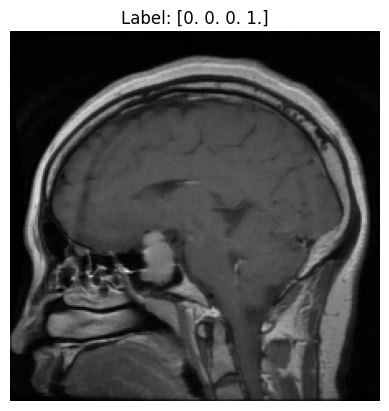

In [14]:
#to acces 1 image 
img = train_ds.take(1)
for i , l in img:
    img1 = i[0]
    plt.imshow(img1.numpy().astype("uint8"))
    plt.title(f"Label: {l[0].numpy()}")
    plt.axis("off")
    plt.show()


Full Batch Shape: (32, 224, 224, 3)


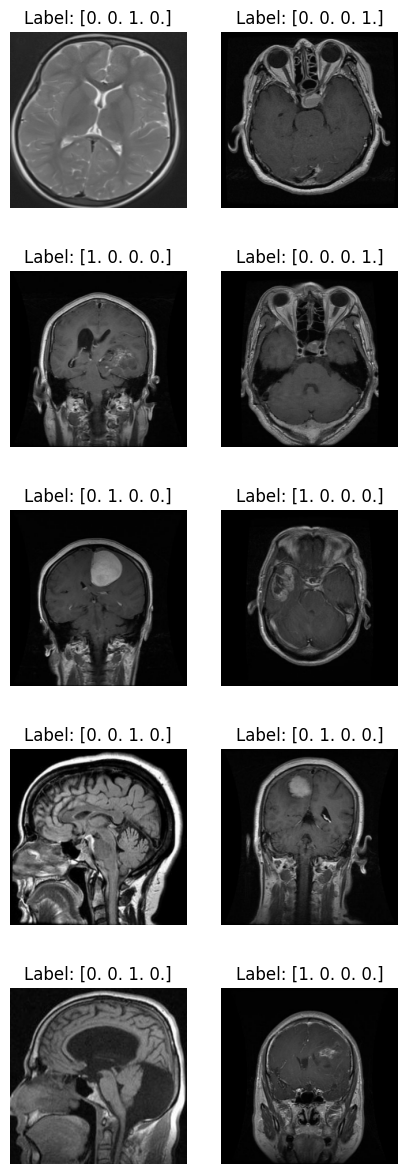

In [15]:
# to priint all image of the batch 
for i, l in train_ds.take(1):
    print(f"Full Batch Shape: {i.shape}") # This will show (32, 224, 224, 3)

    # We need a second loop to go through the 32 images inside 'i'
    plt.figure(figsize=(5, 15))  
    for index in range(10):
        ax = plt.subplot(5, 2, index + 1) # Create a grid (8 rows, 4 columns)
        
        # We grab image 'index' instead of just '0'
        plt.imshow(i[index].numpy().astype("uint8"))
        
        plt.title(f"Label: {l[index].numpy()}")
        plt.axis("off")
    plt.show()

# starting the conveyor pipeline 
key points : 
we will we using vgg16 which is trained on imagenet 
1. since it has 1000 categories we remove the the top layers and replace them with our categories ...use ```include_top = False```
2. input_shape=(224, 224, 3)
3. set ```vgg_base.trainable = False``` to "freeze" the weights and prevent them from being updated during training, leveraging the pre-trained knowledge. 



In [16]:
from tensorflow.data import AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

my initial choice was vgg16 but since its too heavy i had to switch ```MobileNetV2```

but still the logic remains the same
```python
from tensorflow.keras.applications import VGG16

#create a vgg16 object specify to use weights / knowledge accquired by imagenet and can specify inp size also but ensure include top is false 
vgg_base = VGG16(weights="imagenet", input_shape=(224,224,3), include_top=False)
vgg_base.trainable = False

#vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
```

In [17]:
from tensorflow.keras.applications import MobileNetV2

# Replace VGG16 with this:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [18]:
#model training 
from tensorflow.keras import layers, models

model = models.Sequential([
    # Step 1: Preprocessing (Remains the same)
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.RandomFlip("horizontal"),  #this works for traing(onyl for model.fit not model.predict)
    layers.RandomRotation(0.1),

    # Step 2: The VGG16 Base
    base_model,

    # Step 3: Your Custom "Head" (Classifier)
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # Helps prevent overfitting in MRI data: Dropout randomly disables neurons during training to prevent dependency, and is automatically disabled during inference.
    layers.Dense(4, activation='softmax') # Based on your previous label [0,0,1,0], you have 4 classes
])



In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# now we can move to traing and evaluation and prediction 

In [20]:
EPOCHS = 10 # Start small to see if it works

hist = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)
# The hist object: This stores your accuracy and loss for every epoch, which is vital for your project report.

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6965 - loss: 3.8125 - val_accuracy: 0.5254 - val_loss: 1.1421
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7840 - loss: 0.5893 - val_accuracy: 0.5533 - val_loss: 1.2365
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7742 - loss: 0.5742 - val_accuracy: 0.6091 - val_loss: 1.3403
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8045 - loss: 0.5058 - val_accuracy: 0.5787 - val_loss: 1.2690
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8031 - loss: 0.5446 - val_accuracy: 0.6218 - val_loss: 1.5123
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8132 - loss: 0.4815 - val_accuracy: 0.6371 - val_loss: 1.6029
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8359 - loss: 0.4287 - val_accuracy: 0.6447 - val_loss: 1.2259
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8491 - loss: 0.3806 - val_accuracy: 0.6396 - v

What model.summary() Tells YouWhen you run this, 
you get a structural map of your neural network. It displays:
1. Layer Names & Types: You will see the mobilenetv2 block 
2. followed by your custom Flatten and Dense layers.
3. Output Shape: This confirms the dimensions of the tensor as it moves through each layer (e.g., how it goes from $224 \times 224$ down to your 4 class predictions).
4. Param Count: It shows Total params, Trainable params, and Non-trainable params.Since you set base_model.trainable = False, you will see millions of "Non-trainable" params (the frozen weights) and only a few thousand "Trainable" ones (your custom head).

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,430,798 (192.38 MB)

 Trainable params: 16,057,604 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 32,115,210 (122.51 MB)

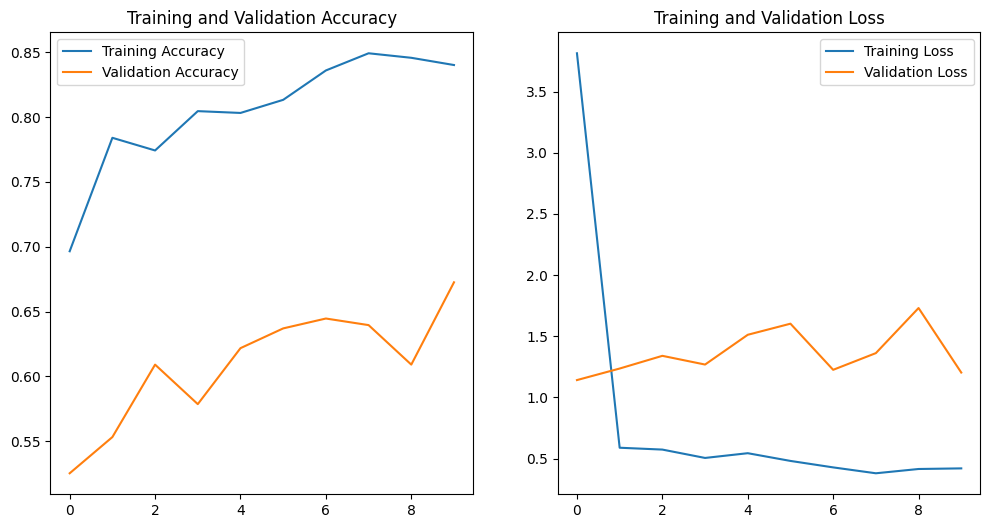

In [22]:
#acc and loss 

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
# This will give you the final Loss and Accuracy
test_loss, test_acc = model.evaluate(test_ds)

print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6726 - loss: 1.2036
Final Test Accuracy: 67.26%
Final Test Loss: 1.2036


In [25]:
# Saving the model
model.save('brain_mri_model_final.h5')
print("Model saved and ready for deployment!")

Model saved and ready for deployment!
